In [1]:
#Boiler plate imports
import pandas as pd
import sys
from time import time
import matplotlib.pyplot as plt

#SBND imports
s0 = time()
sys.path.append('/exp/sbnd/app/users/brindenc/analyze_sbnd/pyana')
from sbnd.general import utils
from sbnd.cafclasses.slice import CAFSlice
from sbnd.cafclasses.pfp import PFP

#Constants
from sbnd.numu.numu_constants import *
from sbnd.prism import PRISM_BINS
from sbnd.constants import *

#Plotters
from sbnd.plotlibrary import makeplot
from sbnd.general import plotters

s1 = time()
print(f'SBND imports: {s1-s0:.2f} s')

%load_ext autoreload
%autoreload 2

# 1. Load Data

In [102]:
#Constants/variables
DATA_DIR  = '/exp/sbnd/data/users/brindenc/analyze_sbnd/numu/v09_78_04_wc_pandora'
#DATA_DIR = '/exp/sbnd/data/users/brindenc/ML/test_fcl/debug_trackid/v4'
FNAME = 'single_processed.df'
#FNAME = 'single_cut_cosmics_processed.df'
HDR_FNAME = 'single.df'
#FNAME = 'all_processed.df'
#HDR_FNAME = 'all.df'
#FNAME = 'test_processed.df'
#HDR_FNAME = 'test.df'
NOM_POT = 0.6e20 # stats for first run
LABEL = 'SBND Work in Progress\n0.6e20 POT'
PLOT_DIR = f'Plots/reco_{plotters.day}'
SAVE_PLOT = False


In [96]:
#Get data and POT
pfp = PFP.load(f'{DATA_DIR}/{FNAME}','pfp'
               ,prism_bins=PRISM_BINS
               ,momentum_bins=MOMENTUM_BINS
               ,costheta_bins=COSTHETA_BINS
               ,pot=NOM_POT)
slc = CAFSlice.load(f'{DATA_DIR}/{FNAME}','slice'
                    ,prism_bins=PRISM_BINS
                    ,pot=NOM_POT)
hdr = pd.read_hdf(f'{DATA_DIR}/{HDR_FNAME}',key='hdr')
SAMPLE_POT = hdr.pot.sum()

#Scale to nominal POT
print(f'--scaled by {NOM_POT/SAMPLE_POT:.2f}')
pfp.scale_to_pot(NOM_POT,SAMPLE_POT)
slc.scale_to_pot(NOM_POT,SAMPLE_POT)

--scaled by 6.93
--scaling to POT: 8.65e+18 -> 6.00e+19
--scaling to POT: 8.65e+18 -> 6.00e+19


In [97]:
CUTS = ['cosmic','fv','trk','has_muon']
pur,eff,f1 = slc.get_pur_eff_f1(['cosmic','fv','trk','has_muon'])
pur,eff,f1

(array([0.21441237, 0.50252181, 0.68067441, 0.69851779, 0.8006998 ]),
 array([1.        , 0.87595162, 0.7239054 , 0.7175484 , 0.64997875]),
 array([1.        , 0.63865546, 0.70162461, 0.70790522, 0.71750955]))

## 2 True event type distributions

In [104]:
#Get interaction types - won't work if there are no events of a given type
#slc_unk = CAFSlice(slc.data[slc.data.truth.event_type == -1])
slc_numucc = CAFSlice(slc.data[slc.data.truth.event_type == 0])
slc_nc = CAFSlice(slc.data[slc.data.truth.event_type == 1])
slc_nuecc = CAFSlice(slc.data[slc.data.truth.event_type == 2])
slc_cosmic = CAFSlice(slc.data[slc.data.truth.event_type == 3])
slc_dirt = CAFSlice(slc.data[slc.data.truth.event_type == 4])
slcs = [slc_numucc,slc_nc,slc_nuecc,slc_cosmic,slc_dirt]

#Get associated PFPs
#pfp_unk = pfp.get_reference_df(slc_unk)
pfp_numucc_df = pfp.get_reference_df(slc_numucc)
pfp_nc_df = pfp.get_reference_df(slc_nc)
pfp_nuecc_df = pfp.get_reference_df(slc_nuecc)
pfp_cosmic_df = pfp.get_reference_df(slc_cosmic)
pfp_dirt_df = pfp.get_reference_df(slc_dirt)

pfp_dfs = [pfp_numucc_df,pfp_nc_df,pfp_nuecc_df,pfp_cosmic_df,pfp_dirt_df]

In [105]:
#Get label info
labels = []
names = []
colors = []

for key,item in EVENT_TYPE_LIST.items():
    if key == -1: #no unknown for now
        continue
    labels.append(item[0])
    names.append(item[1])
    colors.append(item[2])

weights = [s.data.genweight for s in slcs]

In [106]:
def create_hist(series,labels,dens,cut_desc='',xlabel='',colors=None,weights=None,bins=20,cut='',savename='hist'
                ,stat_label=''):
    
    if dens:
        histtype = 'step'
        alpha = 0.9
    else:
        histtype = 'barstacked'
        alpha = 0.8
    fig,ax = makeplot.plot_hist(series,labels,xlabel=xlabel,colors=colors,weights=weights
                   ,histtype=histtype,lw=2,bins=bins,alpha=alpha,density=dens)
    if dens: ax.set_ylabel('Density')
    else: ax.set_ylabel('Events')
    plotters.add_label(ax,LABEL,where='topleft',color='gray',alpha=0.9,fontsize=10)
    plotters.add_label(ax,stat_label,where='bottomrightoutside',fontsize=10)
    plotters.add_label(ax,cut_desc,where='bottomrightoutside',color='black',fontsize=12)
    plotters.set_style(ax)
    if SAVE_PLOT:
        if dens: plot_dir = f'{PLOT_DIR}/{cut}/dens'
        else: plot_dir = f'{PLOT_DIR}/{cut}/counts'
        plotters.save_plot(f'{savename}',fig=fig,folder_name=plot_dir)
        plt.close()
    return fig,ax

In [109]:
_slcs = [s.copy() for s in slcs]
_weights = [w.copy() for w in weights]
cut = 'precut'
for i,cut in enumerate(['precut']+CUTS):
    #Apply cut
    if cut != 'precut':
        [s.apply_cut(cut) for s in _slcs] 
    _weights = [s.data.genweight for s in _slcs] 
    cut_desc = f'{cut}:' + '\n' + f'Pur = {pur[i]:.2f}' + '\n' + f'Eff = {eff[i]:.2f}' + '\n' + f'F1 = {f1[i]:.2f}'  
    
    #Best muon info
    costheta = [s.data.best_muon.costheta for s in _slcs]
    momentum = [s.data.best_muon.p for s in _slcs]
    tcostheta = [s.data.best_muon.truth.p.costheta for s in _slcs]
    tmomentum = [s.data.best_muon.truth.p.genp.tot for s in _slcs]

    #Scores
    nu_scores = [s.data.nu_score for s in _slcs]
    fmatch_scores = [s.data.fmatch.score for s in _slcs]


    #Number of particles
    npfps = [s.data.npfp for s in _slcs]
    ntrks = [s.data.ntrk for s in _slcs]
    nshws = [s.data.nshw for s in _slcs]
    tnpfps = [s.data.truth.npfp for s in _slcs]
    tntrks = [s.data.truth.ntrk for s in _slcs]
    tnshws = [s.data.truth.nshw for s in _slcs]

    nmuons = [s.data.reco.pdg_13 for s in _slcs]
    tnmuons = [s.data.truth.pdg_13 for s in _slcs]

    #Bins
    nbins = np.arange(0,10,1)
    bdt_bins = np.arange(-0.05,1.05,0.05)
    for dens in [False,True]:
        #Reco costheta
        fig,ax = create_hist(costheta,labels,dens,cut_desc=cut_desc,xlabel=r'$\cos\theta_{\mu,reco}$',colors=colors,weights=_weights,bins=np.arange(-1,1.1,0.1),cut=cut,savename='reco_costheta')
        #Reco momentum
        fig,ax = create_hist(momentum,labels,dens,cut_desc=cut_desc,xlabel=r'Reco $p_{\mu,reco}$ [GeV]',colors=colors,weights=_weights,bins=np.arange(0,2.5,0.1),cut=cut,savename='reco_momentum')
        #Truth costheta
        fig,ax = create_hist(tcostheta,labels,dens,cut_desc=cut_desc,xlabel=r'$\cos\theta_{\mu,truth}$',colors=colors,weights=_weights,bins=np.arange(-1,1.1,0.1),cut=cut,savename='true_costheta')
        #Truth momentum
        fig,ax = create_hist(tmomentum,labels,dens,cut_desc=cut_desc,xlabel=r'Truth $p_{\mu,truth}$ [GeV]',colors=colors,weights=_weights,bins=np.arange(0,2.5,0.1),cut=cut,savename='true_momentum')
        #Number of reco muons
        fig,ax = create_hist(nmuons,labels,dens,cut_desc=cut_desc,xlabel=r'Reconstructed Muons',colors=colors,weights=_weights,bins=nbins,cut=cut,savename='nmu')
        #Pandora nu score
        fig,ax = create_hist(nu_scores,labels,dens,cut_desc=cut_desc,xlabel=r'Pandora $\nu$-score',colors=colors,weights=_weights,bins=bdt_bins,cut=cut,savename='nu_score')
        #Flash matching score hist
        fig,ax = create_hist(fmatch_scores,labels,dens,cut_desc=cut_desc,xlabel='Flash match score',colors=colors,weights=_weights,bins=np.arange(0,50,2),cut=cut,savename='fmatch_score')
        #PFP
        fig,ax = create_hist(npfps,labels,dens,cut_desc=cut_desc,xlabel=r'Number of PFPs',colors=colors,weights=_weights,bins=nbins,cut=cut,savename='npfp')
        #Trks
        fig,ax = create_hist(ntrks,labels,dens,cut_desc=cut_desc,xlabel=r'Number of tracks',colors=colors,weights=_weights,bins=nbins,cut=cut,savename='ntrk')
        #Shws
        fig,ax = create_hist(nshws,labels,dens,cut_desc=cut_desc,xlabel=r'Number of showers',colors=colors,weights=_weights,bins=nbins,cut=cut,savename='nshw')
        #Truth PFP
        fig,ax = create_hist(tnpfps,labels,dens,cut_desc=cut_desc,xlabel=r'Number of truth PFPs',colors=colors,weights=_weights,bins=nbins,cut=cut,savename='tnpfp')
        #Truth Trks
        fig,ax = create_hist(tntrks,labels,dens,cut_desc=cut_desc,xlabel=r'Number of truth tracks',colors=colors,weights=_weights,bins=nbins,cut=cut,savename='tntrk')
        #Truth Shws
        fig,ax = create_hist(tnshws,labels,dens,cut_desc=cut_desc,xlabel=r'Number of truth showers',colors=colors,weights=_weights,bins=nbins,cut=cut,savename='tnshw')
    

### 2.1 Precut distributions

<__array_function__ internals>:180: RuntimeWarning: Converting input from bool to <class 'numpy.uint8'> for compatibility.


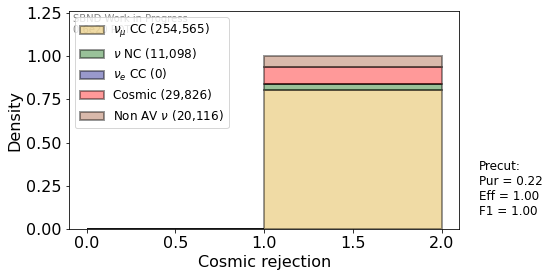

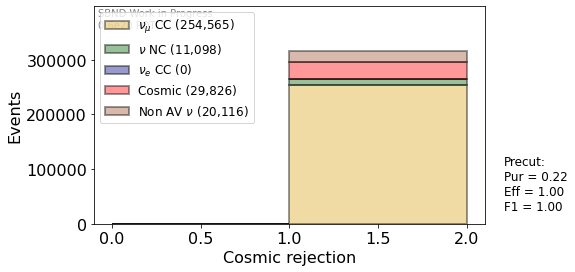

In [89]:
#Cosmic rejection
cosmic_rejection = [s.data.cut.cosmic for s in slcs]
#[s.data.cut.total]
#weights = [s.data[s.data.cut.total].genweight for s in slcs]
cut_desc = 'Precut:' + '\n' + f'Pur = {pur[0]:.2f}' + '\n' + f'Eff = {eff[0]:.2f}' + '\n' + f'F1 = {f1[0]:.2f}'
for dens in [True,False]:
    fig,ax = makeplot.plot_hist(cosmic_rejection,labels,xlabel=r'Cosmic rejection',colors=colors,weights=weights,edgecolor='k'
                                ,histtype='barstacked',lw=2,bins=[0,1,2],density=dens,alpha=0.4)
    if dens: ax.set_ylabel('Density')
    else: ax.set_ylabel('Events')
    ax.set_ylim(None,ax.get_ylim()[1]*1.2) #small padding on top
    plotters.add_label(ax,LABEL,where='topleft',color='gray',fontsize=10)
    plotters.add_label(ax,cut_desc,where='bottomrightoutside',color='black',fontsize=12)
    plotters.set_style(ax)
    if SAVE_PLOT:
        if dens: plot_dir = f'{PLOT_DIR}/dens'
        else: plot_dir = f'{PLOT_DIR}/counts'
        plotters.save_plot('cosmic_rejection_precut',fig=fig,folder_name=plot_dir)
        plt.close()

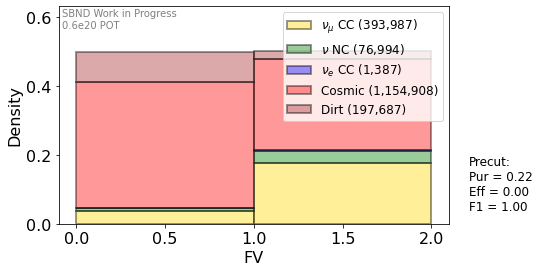

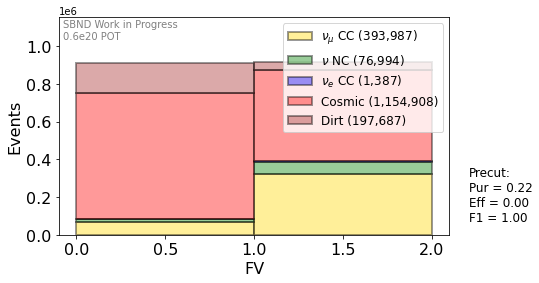

In [100]:
#FV
fv = [s.data.cut.fv for s in slcs]
cut_desc = 'Precut:' + '\n' + f'Pur = {pur[0]:.2f}' + '\n' + f'Eff = {eff[0]:.2f}' + '\n' + f'F1 = {f1[0]:.2f}'
for dens in [True,False]:
    fig,ax = makeplot.plot_hist(fv,labels,xlabel=r'FV',colors=colors,weights=weights,edgecolor='k'
                                ,histtype='barstacked',lw=2,bins=[0,1,2],density=dens,alpha=0.4)
    if dens: ax.set_ylabel('Density')
    else: ax.set_ylabel('Events')
    ax.set_ylim(None,ax.get_ylim()[1]*1.2) #small padding on top
    plotters.add_label(ax,LABEL,where='topleft',color='gray',fontsize=10)
    plotters.add_label(ax,cut_desc,where='bottomrightoutside',color='black',fontsize=12)
    plotters.set_style(ax)
    if SAVE_PLOT:
        if dens: plot_dir = f'{PLOT_DIR}/dens'
        else: plot_dir = f'{PLOT_DIR}/counts'
        plotters.save_plot('fv_precut',fig=fig,folder_name=plot_dir)
        plt.close()

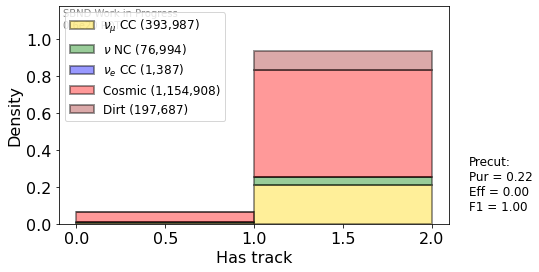

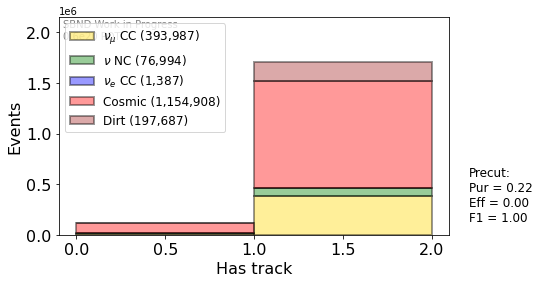

In [101]:
#has trk
has_trk = [s.data.cut.trk for s in slcs]
cut_desc = 'Precut:' + '\n' + f'Pur = {pur[0]:.2f}' + '\n' + f'Eff = {eff[0]:.2f}' + '\n' + f'F1 = {f1[0]:.2f}'
for dens in [True,False]:
    fig,ax = makeplot.plot_hist(has_trk,labels,xlabel=r'Has track',colors=colors,weights=weights,edgecolor='k'
                                ,histtype='barstacked',lw=2,bins=[0,1,2],density=dens,alpha=0.4)
    if dens: ax.set_ylabel('Density')
    else: ax.set_ylabel('Events')
    ax.set_ylim(None,ax.get_ylim()[1]*1.2) #small padding on top
    plotters.add_label(ax,LABEL,where='topleft',color='gray',fontsize=10)
    plotters.add_label(ax,cut_desc,where='bottomrightoutside',color='black',fontsize=12)
    plotters.set_style(ax)
    if SAVE_PLOT:
        if dens: plot_dir = f'{PLOT_DIR}/dens'
        else: plot_dir = f'{PLOT_DIR}/counts'
        plotters.save_plot('has_trk_precut',fig=fig,folder_name=plot_dir)
        plt.close()

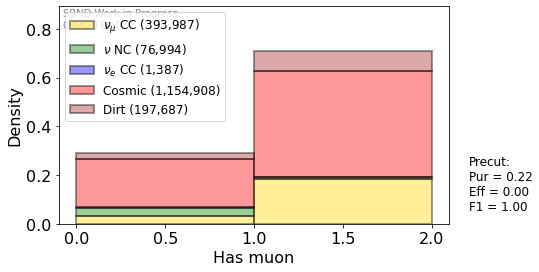

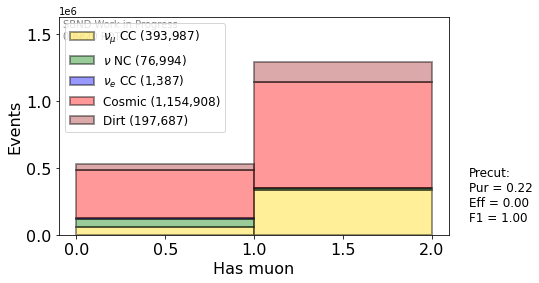

In [102]:
#has muon
has_muon = [s.data.cut.has_muon for s in slcs]
cut_desc = 'Precut:' + '\n' + f'Pur = {pur[0]:.2f}' + '\n' + f'Eff = {eff[0]:.2f}' + '\n' + f'F1 = {f1[0]:.2f}'
for dens in [True,False]:
    fig,ax = makeplot.plot_hist(has_muon,labels,xlabel=r'Has muon',colors=colors,weights=weights,edgecolor='k'
                                ,histtype='barstacked',lw=2,bins=[0,1,2],density=dens,alpha=0.4)
    if dens: ax.set_ylabel('Density')
    else: ax.set_ylabel('Events')
    ax.set_ylim(None,ax.get_ylim()[1]*1.2) #small padding on top
    plotters.add_label(ax,LABEL,where='topleft',color='gray',fontsize=10)
    plotters.add_label(ax,cut_desc,where='bottomrightoutside',color='black',fontsize=12)
    plotters.set_style(ax)
    if SAVE_PLOT:
        if dens: plot_dir = f'{PLOT_DIR}/dens'
        else: plot_dir = f'{PLOT_DIR}/counts'
        plotters.save_plot('has_muon_precut',fig=fig,folder_name=plot_dir)
        plt.close()

## 3 Single Particle

In [110]:
#Reco particles and slices
muon,proton,pion = pfp.get_particles([13,2212,211],use_reco=True)
pfps = [muon,proton,pion]
slc_muon = CAFSlice(muon.get_reference_df(slc))
slc_proton = CAFSlice(proton.get_reference_df(slc))
slc_pion = CAFSlice(pion.get_reference_df(slc))
slcs = [slc_muon,slc_proton,slc_pion]

#True particles and slices
tmuon,tproton,tpion = pfp.get_particles([13,2212,211],use_reco=False)
tpfps = [tmuon,tproton,tpion]
slc_tmuon = CAFSlice(tmuon.get_reference_df(slc))
slc_tproton = CAFSlice(tproton.get_reference_df(slc))
slc_tpion = CAFSlice(tpion.get_reference_df(slc))
tslcs = [slc_tmuon,slc_tproton,slc_tpion]

In [111]:
labels = [r'$\mu$',r'$p$',r'$\pi^\pm$']
names = ['muon','proton','pion']
weights = [p.data.genweight for p in tpfps]

In [112]:
#Track score
trkscores = [p.data.trackScore for p in tpfps]


In [113]:
#Chi2 muon
x2_mu = [p.data.trk.chi2pid.I2.chi2_muon for p in tpfps]
bins = np.arange(0,70,2)
for dens in [True,False]:
    fig,ax = makeplot.plot_hist(x2_mu,labels,xlabel=r'$\chi^2_{\mu}$',weights=weights
                                ,histtype='step',lw=2,bins=bins,density=dens)
    if dens: ax.set_ylabel('Density')
    else: ax.set_ylabel('Events')
    plotters.add_label(ax,LABEL,where='topleft',color='gray',fontsize=10)
    plotters.set_style(ax)
    if SAVE_PLOT:
        if dens: plot_dir = f'{PLOT_DIR}/dens'
        else: plot_dir = f'{PLOT_DIR}/counts'
        plotters.save_plot('x2_mu_precut',fig=fig,folder_name=plot_dir)
        plt.close()

In [114]:
#Chi2 proton
x2_p = [p.data.trk.chi2pid.I2.chi2_proton for p in tpfps]
bins = np.arange(0,250,5)
for dens in [True,False]:
    fig,ax = makeplot.plot_hist(x2_p,labels,xlabel=r'$\chi^2_{p}$',weights=weights
                                ,histtype='step',lw=2,bins=bins,density=dens)
    if dens: ax.set_ylabel('Density')
    else: ax.set_ylabel('Events')
    plotters.add_label(ax,LABEL,where='topleft',color='gray',fontsize=10)
    plotters.set_style(ax)
    if SAVE_PLOT:
        if dens: plot_dir = f'{PLOT_DIR}/dens'
        else: plot_dir = f'{PLOT_DIR}/counts'
        plotters.save_plot('x2_p_precut',fig=fig,folder_name=plot_dir)
        plt.close()

In [115]:
#Chi2 pion
x2_pi = [p.data.trk.chi2pid.I2.chi2_pion for p in tpfps]
bins = np.arange(0,80,2)
for dens in [True,False]:
    fig,ax = makeplot.plot_hist(x2_pi,labels,xlabel=r'$\chi^2_{\pi}$',weights=weights
                                ,histtype='step',lw=2,bins=bins,density=dens)
    if dens: ax.set_ylabel('Density')
    else: ax.set_ylabel('Events')
    plotters.add_label(ax,LABEL,where='topleft',color='gray',fontsize=10)
    plotters.set_style(ax)
    if SAVE_PLOT:
        if dens: plot_dir = f'{PLOT_DIR}/dens'
        else: plot_dir = f'{PLOT_DIR}/counts'
        plotters.save_plot('x2_pion_precut',fig=fig,folder_name=plot_dir)
        plt.close()

In [116]:
#Particle momentum
momenta = [p.data.trk.bestmom for p in tpfps]
bins = np.arange(0,2.5,0.1)
for dens in [True,False]:
    fig,ax = makeplot.plot_hist(momenta,labels,xlabel=r'Reco Momentum [GeV]',weights=weights
                                ,histtype='step',lw=2,bins=bins,density=dens)
    if dens: ax.set_ylabel('Density')
    else: ax.set_ylabel('Events')
    plotters.add_label(ax,LABEL,where='centerright',color='gray',fontsize=10)
    plotters.set_style(ax)
    if SAVE_PLOT:
        if dens: plot_dir = f'{PLOT_DIR}/dens'
        else: plot_dir = f'{PLOT_DIR}/counts'    
        plotters.save_plot('particle_momentum_precut',fig=fig,folder_name=plot_dir)
        plt.close()

In [117]:
#Particle direction cos theta
costhetas = [np.cos(p.data.trk.theta) for p in tpfps]
bins = np.arange(-1,1.1,0.1)
for dens in [True,False]:
    fig,ax = makeplot.plot_hist(costhetas,labels,xlabel=r'Reco cos($\theta$)',weights=weights
                                ,histtype='step',lw=2,bins=bins,density=dens)
    ax.set_xlim(-1,1)
    if dens: ax.set_ylabel('Density')
    else: ax.set_ylabel('Events')
    plotters.add_label(ax,LABEL,where='topleft',color='gray',fontsize=10)
    plotters.set_style(ax)
    if SAVE_PLOT:
        if dens: plot_dir = f'{PLOT_DIR}/dens'
        else: plot_dir = f'{PLOT_DIR}/counts'    
        plotters.save_plot('particle_costheta_precut',fig=fig,folder_name=plot_dir)
        plt.close()

In [118]:
#Particle length
lengths = [p.data.trk.len for p in tpfps]
bins = np.arange(0,600,20)
for dens in [True,False]:
    fig,ax = makeplot.plot_hist(lengths,labels,xlabel=r'Track Length [cm]',weights=weights
                                ,histtype='step',lw=2,bins=bins,density=dens)
    if dens: ax.set_ylabel('Density')
    else: ax.set_ylabel('Events')
    plotters.add_label(ax,LABEL,where='topleft',color='gray',fontsize=10)
    plotters.set_style(ax)
    if SAVE_PLOT:
        if dens: plot_dir = f'{PLOT_DIR}/dens'
        else: plot_dir = f'{PLOT_DIR}/counts'    
        plotters.save_plot('particle_length_precut',fig=fig,folder_name=plot_dir)
        plt.close()